In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun May 10 19:31:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
class GAN():
  def __init__(self):
    self.img_rows = 28
    self.img_cols = 28
    self.channels = 1
    self.img_shape = (self.img_rows, self.img_cols, self.channels)
    self.latent_dim = 64
    optimizer = Adam(0.0001, 0.5)
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss='binary_crossentropy',
                                optimizer=Adam(0.0002, 0.5),
                                metrics=['accuracy'])
    self.generator = self.build_generator()
    z = Input(shape=(self.latent_dim,))
    img = self.generator(z)
    self.discriminator.trainable = False
    validity = self.discriminator(img)
    self.combined = Model(z, validity)
    self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

  def build_generator(self):
      model = Sequential()
      model.add(Dense(256, input_dim=self.latent_dim))
      model.add (ReLU(negative_slope=0.2))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Dense(512))
      model.add (ReLU(negative_slope=0.2))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Dense(1024))
      model.add (ReLU(negative_slope=0.2))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Dense(np.prod(self.img_shape), activation='sigmoid'))
      model.add(Reshape(self.img_shape))
      noise = Input(shape=(self.latent_dim,))
      img = model(noise)
      model.summary()
      return Model(noise, img)

  def build_discriminator(self):
      model = Sequential()
      model.add(Flatten(input_shape=self.img_shape))
      model.add(Dense(512))
      model.add(LeakyReLU(alpha=0.2))
      model.add(Dense(256))
      model.add(LeakyReLU(alpha=0.2))
      model.add(Dense(1, activation='sigmoid'))
      img = Input(shape=self.img_shape)
      validity = model(img)
      model.summary()
      return Model(img, validity)

  def train(self, epochs, batch_size=128, sample_interval=1000):
      (X_train, _), (_, _) = mnist.load_data()
      X_train = X_train / 127.5 - 1.
      X_train = np.expand_dims(X_train, axis=3)
      valid = np.ones((batch_size, 1))
      fake = np.zeros((batch_size, 1))
      for epoch in range(epochs):
          idx = np.random.randint(0, X_train.shape[0], batch_size)
          imgs = X_train[idx]
          noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
          g_loss = self.combined.train_on_batch(noise, valid)
          gen_imgs = self.generator.predict(noise)
          d_loss_real = self.discriminator.train_on_batch(imgs, valid)
          d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
          print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
          if epoch % sample_interval == 0:
            self.sample_images(epoch)
			
  def sample_images(self, epoch):
      noise = np.random.normal(0, 1, (1, gan.latent_dim))
      predictions = gan.generator.predict(noise)
      print(predictions.shape)
      print("Reshaping")
      generated_seq = np.reshape(predictions[0], (28,28))
      print(generated_seq.shape)
      plt.figure(figsize = (5,5))
      plt.imshow(generated_seq,aspect='auto',cmap='gray')
      plt.savefig("/content/drive/My Drive/DL/GAN/Results/GAN_MNIST/%d.png" % epoch)
      plt.show()
      plt.close()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.394503, acc.: 95.31%] [G loss: 0.809602]
(1, 28, 28, 1)
Reshaping
(28, 28)


TypeError: ignored

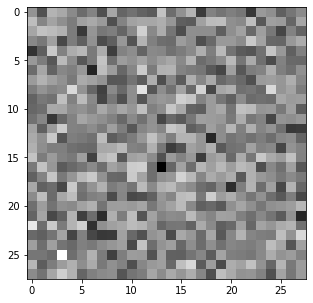

In [12]:
gan = GAN()
gan.train(epochs=50000, batch_size=32, sample_interval=1000)